
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Plotting Diffraction Pattern 

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_07-Plotting_Diffraction_Pattern.ipynb)
 

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2022

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes



## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2022.1.2':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

done


### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library.

In [2]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab notebook
    
# 3D plotting package used
from mpl_toolkits.mplot3d import Axes3D # 3D plotting 

# additional package 
import itertools 
import scipy.constants as const

# Import libraries from the pyTEMlib
import sys
sys.path.insert(0, '../../pyTEMlib')
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # kinematic scattering Library

__notebook_version__ = '2022.01.22'
print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

Populating the interactive namespace from numpy and matplotlib
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2022.2.1
notebook version:  2022.01.22



### Define Silicon crystal

In [3]:
#Initialize the dictionary with all the input
atoms = ks.structure_by_name('Silicon')
print(atoms)

#Reciprocal Lattice 
# We use the linear algebra package of numpy to invert the unit_cell "matrix"
reciprocal_unit_cell = atoms.cell.reciprocal()  # np.linalg.inv(atoms.cell).T # transposed of inverted unit_cell


Lattice(symbols='Si8', pbc=True, cell=[5.43088, 5.43088, 5.43088])


### All Possible and Allowed Reflections

see
- [Structure Factors](CH2_04-Structure_Factors.ipynb)
- [Kinematic Scattering Geometry](CH2_06-Kinematic_Scattering_Geometry.ipynb)
for details

Because the nuclei of the atoms in a material are positive, there is a small acceleration of the electron within the material.

We add this to the contribution to the magnitude of the incident wave-vector. 
The acceleration potential is called *inner potential* and is calculated from the scattering factors $f_e$ according to (Kirkland Eq 6.10:

$$U_{\vec{G}} =  \frac{h^2}{2 \pi m_e e} \frac{1}{V_{unit-cell}} \sum_j f_{e_j} (|\vec{G}|) \exp(-2\pi i \vec{G} \cdot \vec{r_j})$$ 
which reduces for $|\vec{G}| = 0$ to:

$$U_{0} =  \frac{h^2}{2 \pi m_e e} \frac{1}{V_{unit-cell}} \sum_j f_{e_j} (0)$$
 which forms an uniform potential inside the material


In [4]:
# --------------- INPUT ------------------------
zone_hkl = np.array([1, 1, 0])
hkl_max = 35  #  maximum allowed Miller index
Sg_max = 0.03   # 1/Ang  maximum allowed excitation error

acceleration_voltage_V = 200.0 * 1000.0 #V
# -------------------------------------------

wave_length_A = ks.get_wavelength(acceleration_voltage_V)

U_0 = 0  # in (Ang)
# atom form factor of zero reflection angle is the inner potential in 1/A
for atom in atoms:
    U_0 += ks.feq(atom.symbol, 0)
scattering_factor_to_volts = (const.h*1e10)**2 / (2 * np.pi * const.m_e * const.e) / atoms.cell.volume

# Conversion of inner potential to Volts
U_0 =  U_0 * scattering_factor_to_volts

print('The inner potential is {0:.2f}V'.format(U_0))

incident_wave_vector_vacuum = 1/wave_length_A
K0_magnitude = incident_wave_vector = np.sqrt(1/wave_length_A**2 + U_0 )#1/Ang

cent = np.dot(zone_hkl,reciprocal_unit_cell)
cent = cent /np.linalg.norm(cent)* incident_wave_vector

# zone axis in global coordinate system
zone_vector = np.dot(zone_hkl,reciprocal_unit_cell)

h  = np.linspace(-hkl_max,hkl_max, 2*hkl_max+1)    # all evaluated single Miller Indices
hkl  = np.array(list(itertools.product(h, h, h) )) # all evaluated Miller indices
g = np.dot(hkl, reciprocal_unit_cell)              # all evaluated reciprocal lattice points

# Calculate excitation errors for all reciprocal lattice points
## Zuo and Spence, 'Adv TEM', 2017 -- Eq 3:14
S = (K0_magnitude**2-np.linalg.norm(g - cent, axis =1)**2)/(2*K0_magnitude)

# Determine reciprocal lattice points with excitation error less than the maximum allowed one: Sg_max
reflections = abs(S)< Sg_max

Sg = S[reflections]
g_hkl = g[reflections]
hkl = hkl[reflections] 
print ('Of the {0} tested reciprocal lattice points, {1} have an excitation error less than {2:.2f} 1/nm'.format( len(g) , len(g_hkl), Sg_max))

# Calculate Structure Factors

structure_factors = []

base = atoms.positions
for j  in range(len(g_hkl)):
    F = 0
    for atom in atoms:
        f = ks.feq(atom.symbol, np.linalg.norm(g_hkl[j]))
        F += f * np.exp(-2*np.pi*1j*(g_hkl[j]*atom.position).sum())        
    structure_factors.append(F)
F = structure_factors = np.array(structure_factors)

allowed = np.absolute(structure_factors) > 0.000001

print('Of the {0} possible reflection {1} are allowed.'.format(hkl.shape[0], allowed.sum() ) )

# information of allowed reflections
Sg_allowed = Sg[allowed]
hkl_allowed = hkl[allowed][:]
g_allowed = g_hkl[allowed, :]
F_allowed = F[allowed]
intensities = np.absolute(F_allowed)**2 

# forbidden reflections:
forbidden = np.logical_not(allowed)
g_forbidden = g_hkl[forbidden, :]

# Determine Laue Zone for reflections
zone_axis = np.dot(zone_hkl, atoms.cell.array)
Laue_Zone = np.floor(abs(np.dot(hkl_allowed,zone_hkl)))# works only for cubic crystal systems
#Laue_Zone = np.floor(abs(np.dot(g_allowed,zone_axis)) ) # works for all crystal systems
ZOLZ = Laue_Zone ==0
HOLZ = Laue_Zone > 1

print ('Of those, there are {0} in ZOLZ and {1} in HOLZ'.format(ZOLZ.sum(),HOLZ.sum()))

intensities = np.absolute(F_allowed)**2 


The inner potential is 13.90V
Of the 357911 tested reciprocal lattice points, 2109 have an excitation error less than 0.03 1/nm
Of the 2109 possible reflection 405 are allowed.
Of those, there are 57 in ZOLZ and 348 in HOLZ


## Plotting of Ewald Sphere

<IPython.core.display.Javascript object>


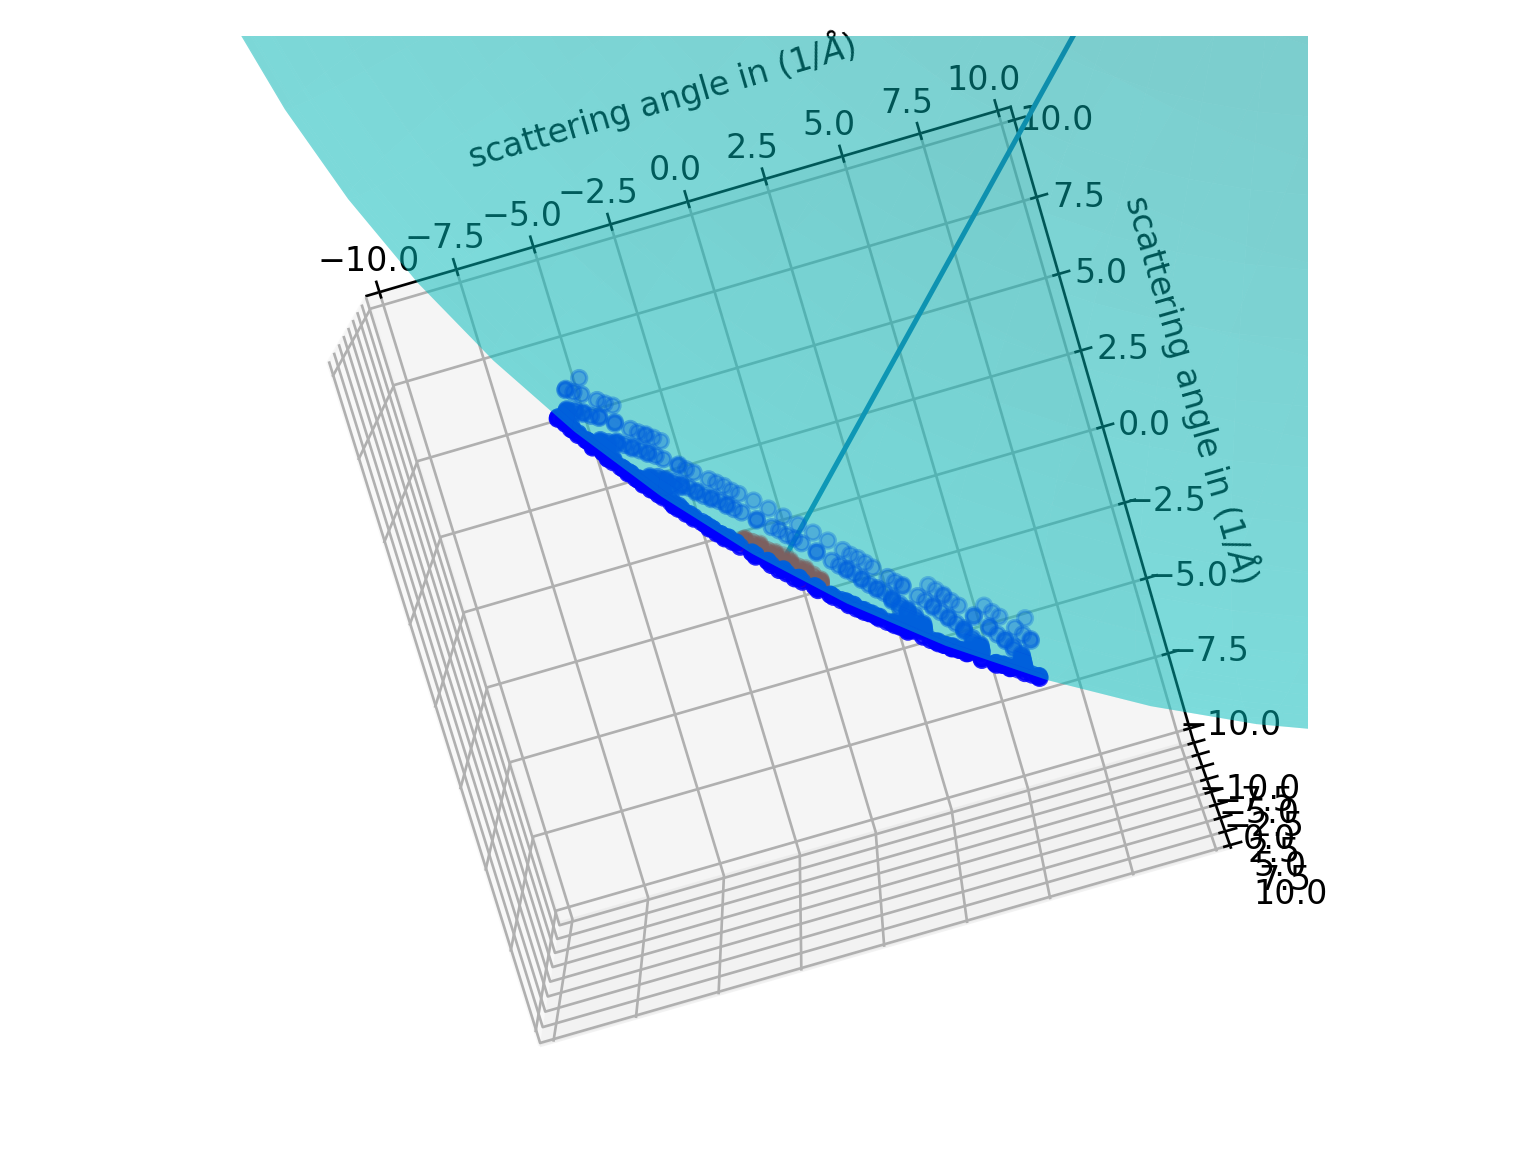

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cent[0], cent[1], cent[2], c='green')
ax.plot((cent[0], 0), (cent[1], 0), (cent[2], 0)) 

# draw sphere
u, v = np.mgrid[0:2*np.pi:80j, 0:np.pi:40j]
x = np.cos(u)*np.sin(v)*K0_magnitude+cent[0]
y = np.sin(u)*np.sin(v)*K0_magnitude+cent[1]
z = np.cos(v)*K0_magnitude+cent[2]

ax.scatter(g_allowed[ZOLZ,0], g_allowed[ZOLZ,1], g_allowed[ZOLZ,2], c='red')
ax.scatter(g_allowed[HOLZ,0], g_allowed[HOLZ,1], g_allowed[HOLZ,2], c='blue')
ax.plot_surface( x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
ax.set_xlabel('scattering angle in (1/$\AA$)')
ax.set_ylabel('scattering angle in (1/$\AA$)')
#ax.set_aspect("equal"); 
plt.tight_layout(); plt.show()

<IPython.core.display.Javascript object>


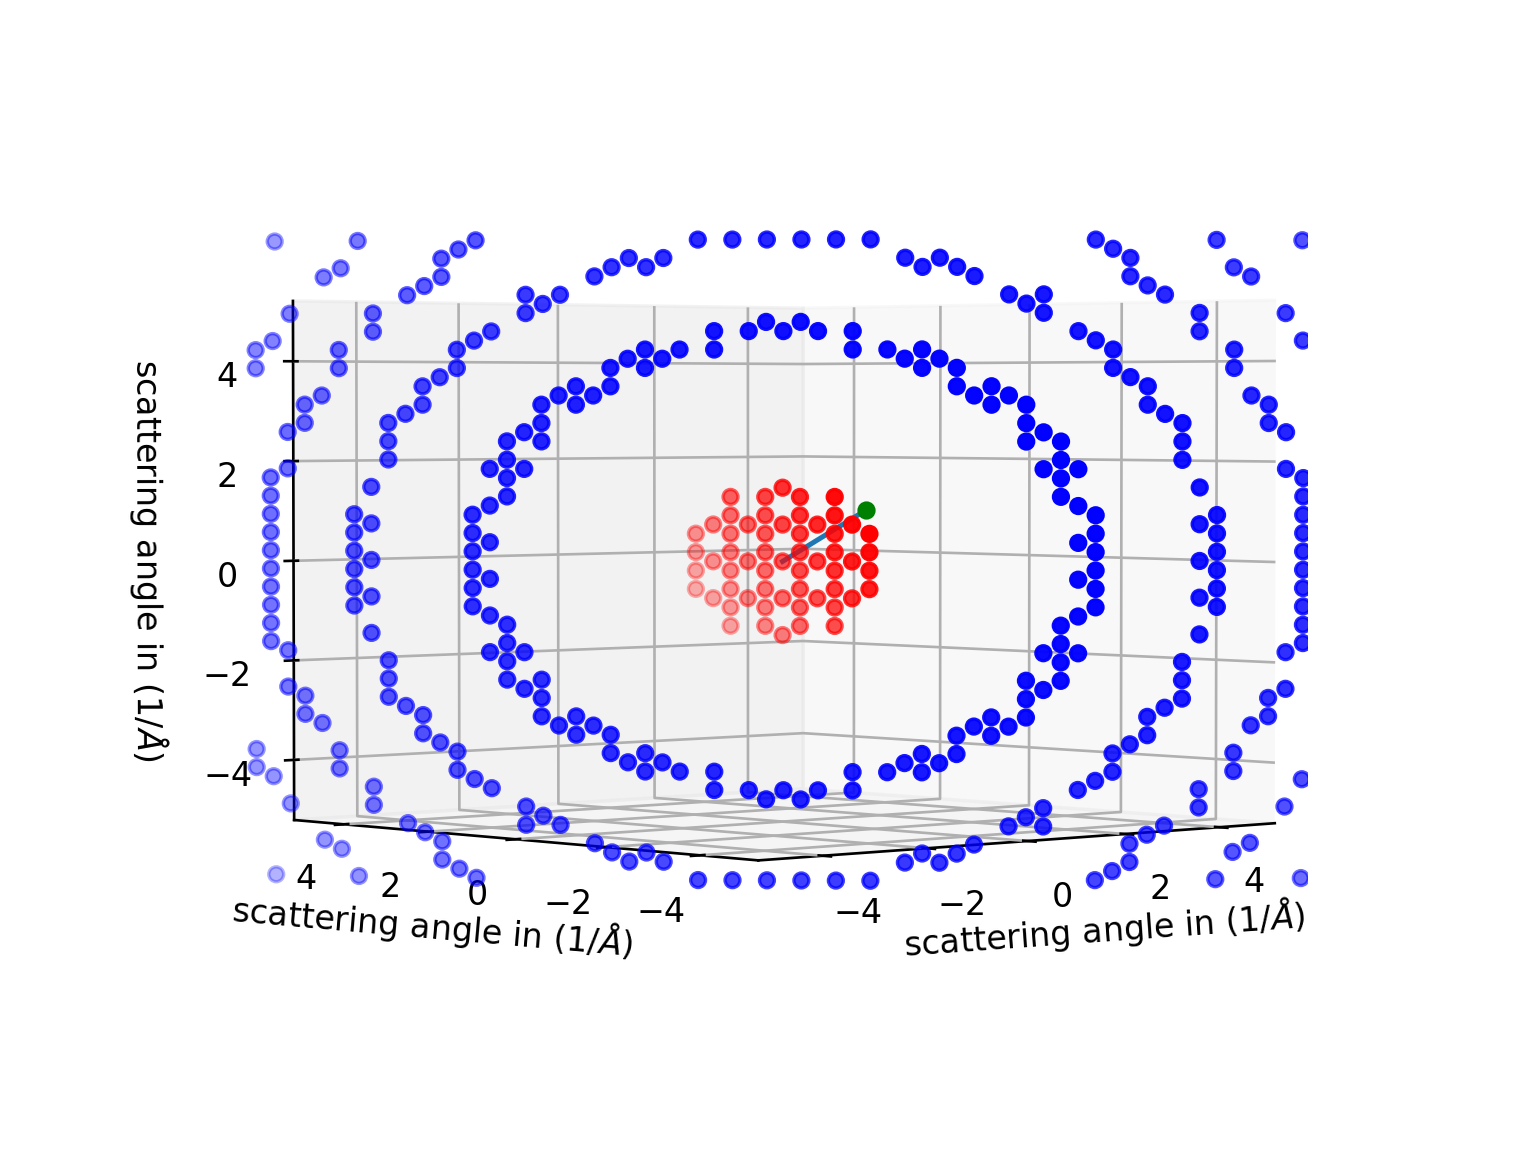

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(g_allowed[ZOLZ,0], g_allowed[ZOLZ,1], g_allowed[ZOLZ,2], c='red')
ax.scatter(g_allowed[HOLZ,0], g_allowed[HOLZ,1], g_allowed[HOLZ,2], c='blue')

ax.scatter(cent[0], cent[1], cent[2], c='green')
ax.plot((cent[0], 0), (cent[1], 0), (cent[2],0)) 
33
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])
ax.set_xlabel('scattering angle in (1/$\AA$)')
ax.set_ylabel('scattering angle in (1/$\AA$)')
ax.set_zlabel('scattering angle in (1/$\AA$)')

#ax.set_aspect("equal"); 
plt.tight_layout(); 

## Projection
We need to project the active reciprocal points onto the plane perpendicular to the zone axis.

For that we tilt the zone axis onto the z-axis

We use the spherical coordinates to determine the rotation matrix


In [7]:
def get_rotation_matrix(zone):
    
    #spherical coordinates of zone
    r = np.linalg.norm(zone)
    theta = np.arccos(zone[2]/r)
    if zone[0] < 0:
        theta = -theta
    if zone[0] == 0:
        phi= np.pi/2
    else: 
        phi = (np.arctan(zone[1]/zone[0]))

    print('Rotation theta ',np.degrees(theta),' phi ',np.degrees(phi))

    #first we rotate phi about z-axis
    c, s = np.cos(phi), np.sin(phi)
    rotz = np.array([[c, -s , 0],[s,c,0],[0,0,1]])

    # second we rotate theta about y-axis
    c, s = np.cos(theta), np.sin(theta)
    roty = np.array([[c, 0 ,s],[0,1,0],[-s,0,c]])
    
    # the rotation now makes z-axis coincide with plane normal
    return np.dot(rotz,roty), np.degrees(theta), np.degrees(phi)
# zone axis in global coordinate system

zone_vector = np.dot(zone_hkl,reciprocal_unit_cell)
rotation_matrix, theta, phi = get_rotation_matrix(zone_vector)

print(rotation_matrix)

print('\n Zone axis can now be rotated parallel to z axis')
print(np.dot(zone_vector,rotation_matrix))

Rotation theta  90.0  phi  45.0
[[ 4.32978028e-17 -7.07106781e-01  7.07106781e-01]
 [ 4.32978028e-17  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00  0.00000000e+00  6.12323400e-17]]

 Zone axis can now be rotated parallel to z axis
[1.59450412e-17 4.81851563e-18 2.60402285e-01]


### Rotation
We use the rotation matrix to rotate all lattice vectors

In [8]:
K0_vector_rotated = np.dot(cent, rotation_matrix)
cent_rotated = K0_vector_rotated
print(cent_rotated)

g_hkl_rotated = np.dot(g_allowed, rotation_matrix)

[ 2.45219701e-15 -1.17235322e-15  4.00474164e+01]


Now we can plot these diffraction spots in 2D by just setting the z-coordinate to zero. That is our projection procedure.

<IPython.core.display.Javascript object>


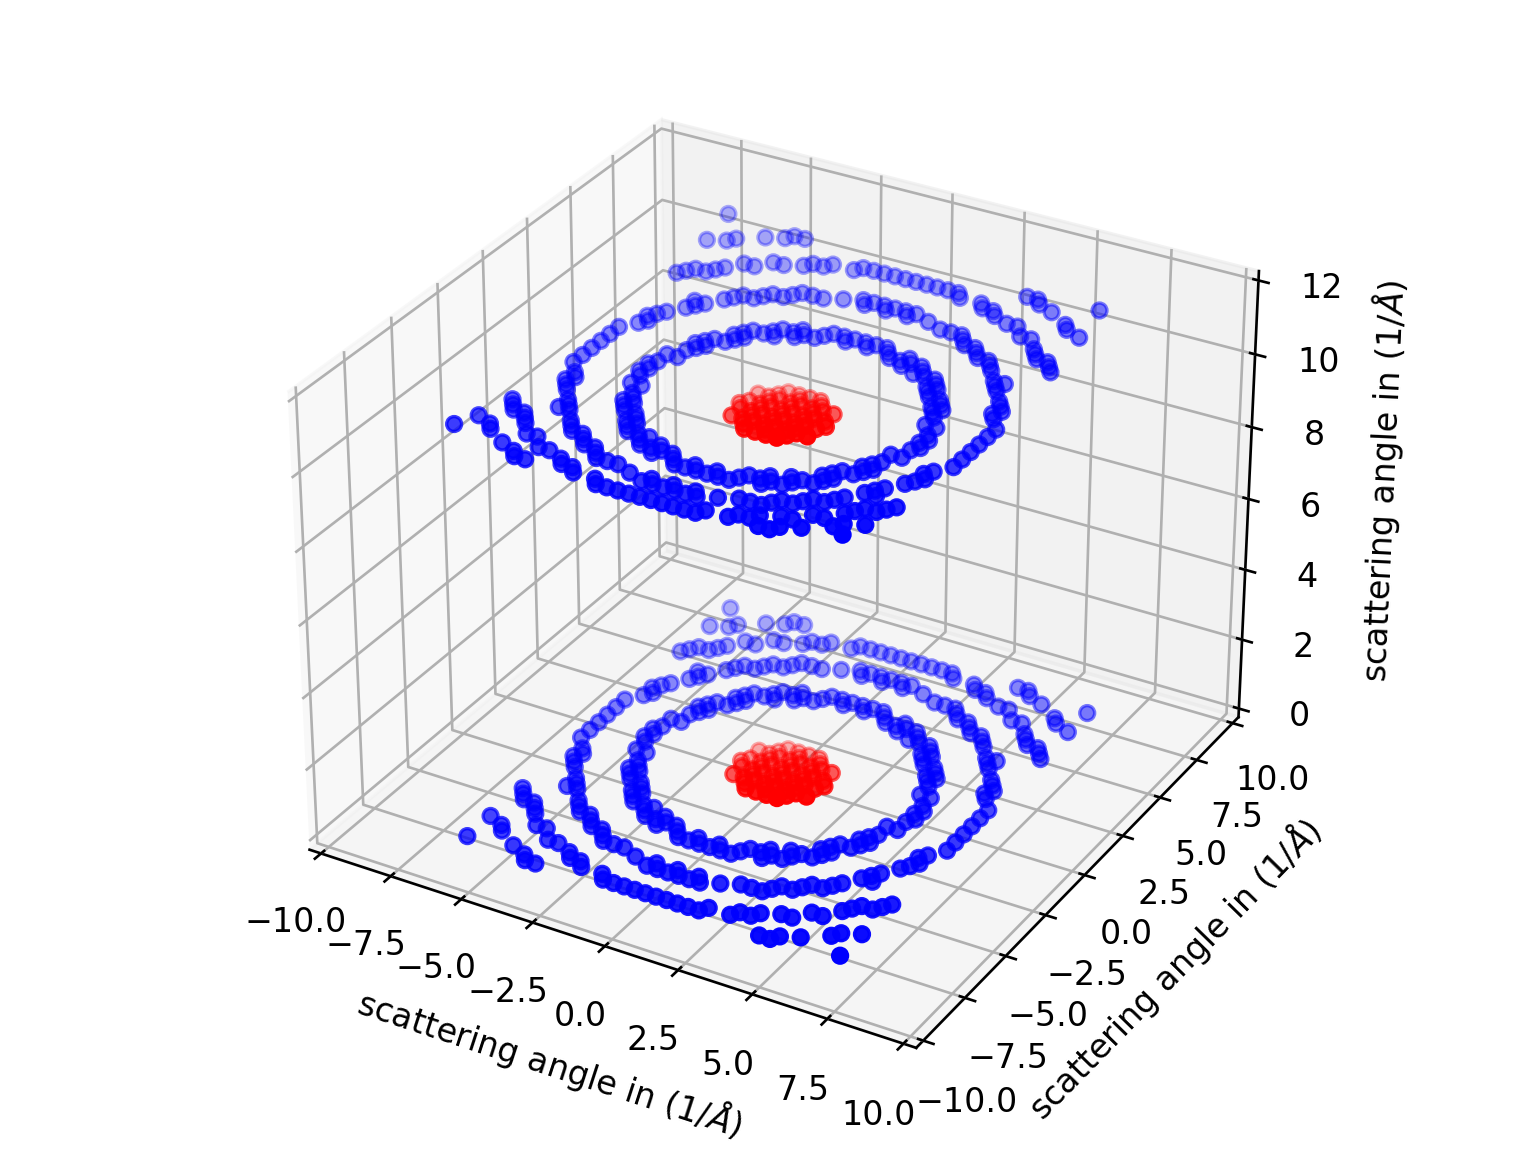

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], g_hkl_rotated[ZOLZ,2]+10, c='red')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], g_hkl_rotated[HOLZ,2]+10, c='blue')

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], 0, c='red')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], 0, c='blue')

ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
ax.set_zlim([0,12])
ax.set_xlabel('scattering angle in (1/$\AA$)')
ax.set_ylabel('scattering angle in (1/$\AA$)')
ax.set_zlabel('scattering angle in (1/$\AA$)')

#ax.set_aspect("equal"); 
plt.tight_layout(); plt.show()

In the above graph the z-axis is much smaller than the x-, y-axis.

In perspective to the incident beam wave vector the ewald sphere appears almost flat.

<IPython.core.display.Javascript object>


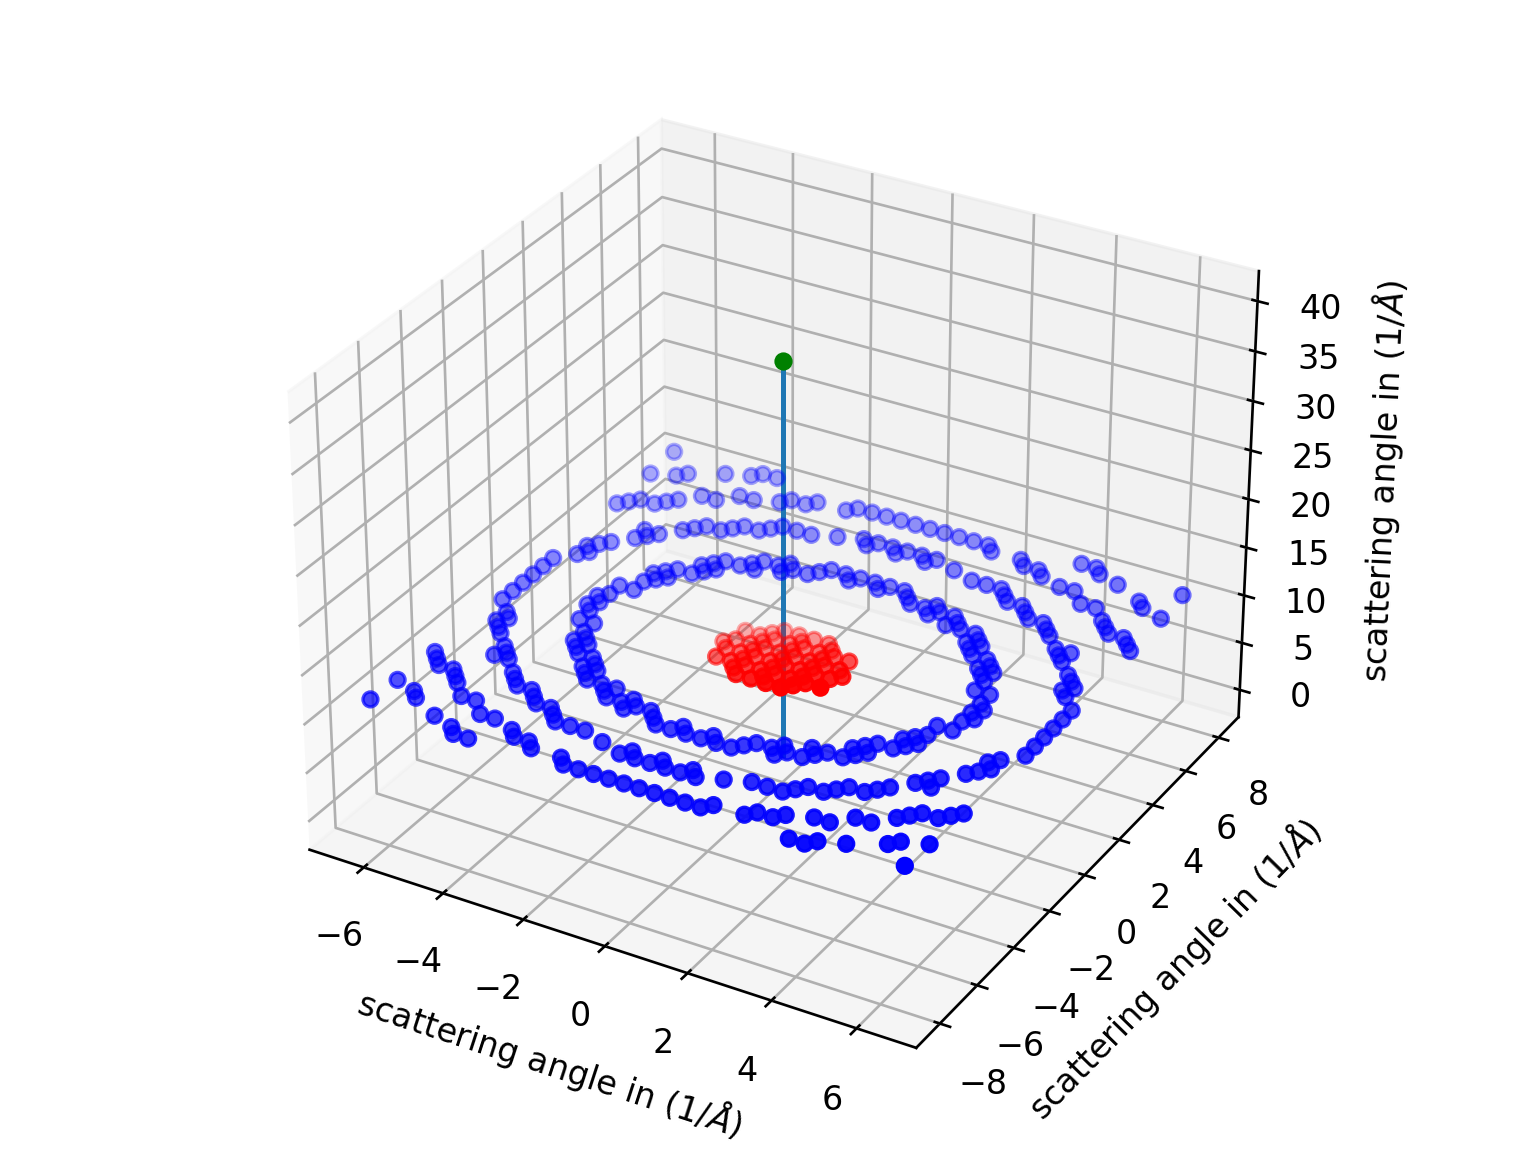

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], g_hkl_rotated[ZOLZ,2]+10, c='red')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], g_hkl_rotated[HOLZ,2]+10, c='blue')

ax.scatter(cent_rotated[0], cent_rotated[1], cent_rotated[2], c='green')
ax.plot((cent_rotated[0], 0), (cent_rotated[1], 0), (cent_rotated[2],0)) 
#ax.set_aspect("equal"); 
ax.set_xlabel('scattering angle in (1/$\AA$)')
ax.set_ylabel('scattering angle in (1/$\AA$)')
ax.set_zlabel('scattering angle in (1/$\AA$)')

plt.tight_layout();

### 2D projection
To compare this simulation with an experimental diffraction pattern, we only need the 2D projection.

Please note that all calculations were done without rotation. Only the plotting requires that. So rotation and setting the z-coordinate to zero is our projection procedure.

<IPython.core.display.Javascript object>


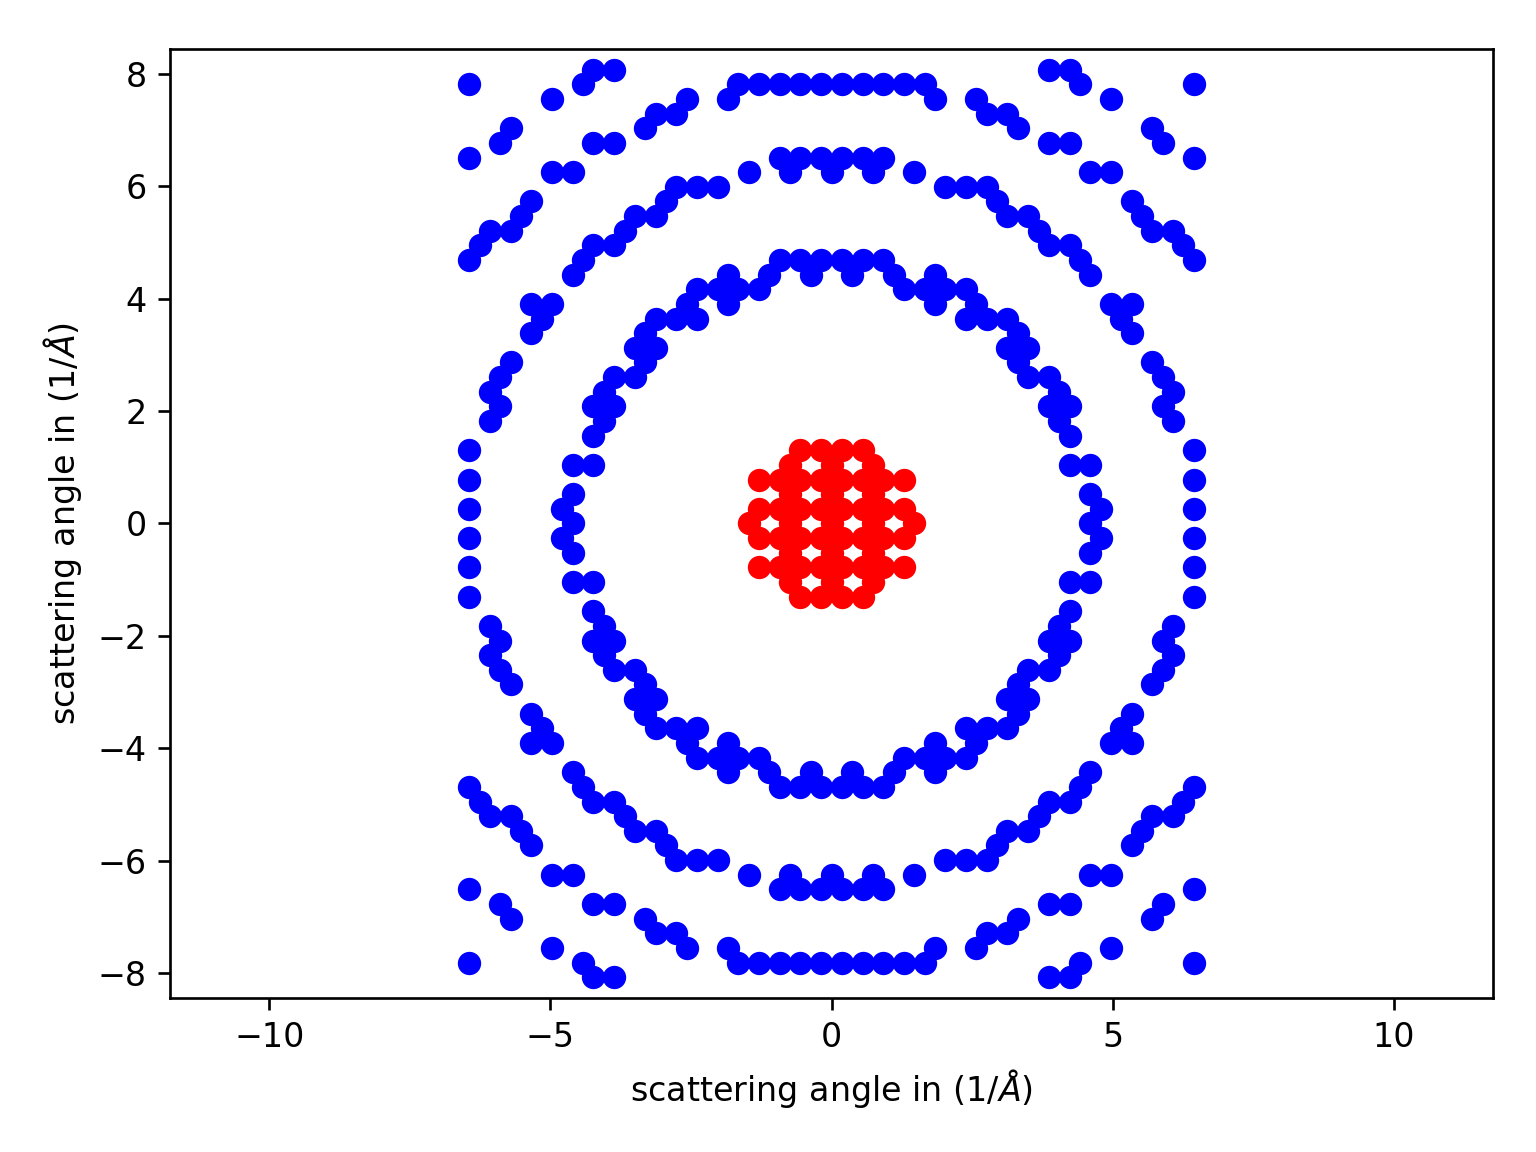

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], c='red')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], c='blue')
## Add indices
#for i in range (ZOLZ_plot.sum()):
#    ax.text(g_hk_rotated[ZOLZ_plot][i,0]-2.5, g_hk_rotated[ZOLZ_plot][i,1]+1.2,hkl[ZOLZ_plot][i], fontsize=10)
#for i in range (HOLZ_plot.sum()):
#    ax.text(g_hk_rotated[HOLZ_plot][i,0]-2.5, g_hk_rotated[HOLZ_plot][i,1]+1.2,hkl[HOLZ_plot][i], fontsize=10)
ax.axis("equal")
ax.set_xlabel('scattering angle in (1/$\AA$)')
ax.set_ylabel('scattering angle in (1/$\AA$)')
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])

plt.tight_layout();

### Forbidden Reflections
We can now pot the forbidden reflections into this diffraction pattern.

As can be seen the first order Laue Zone (SOLZ) is completely forbidden as are all the other odd Laue Zones.


<IPython.core.display.Javascript object>


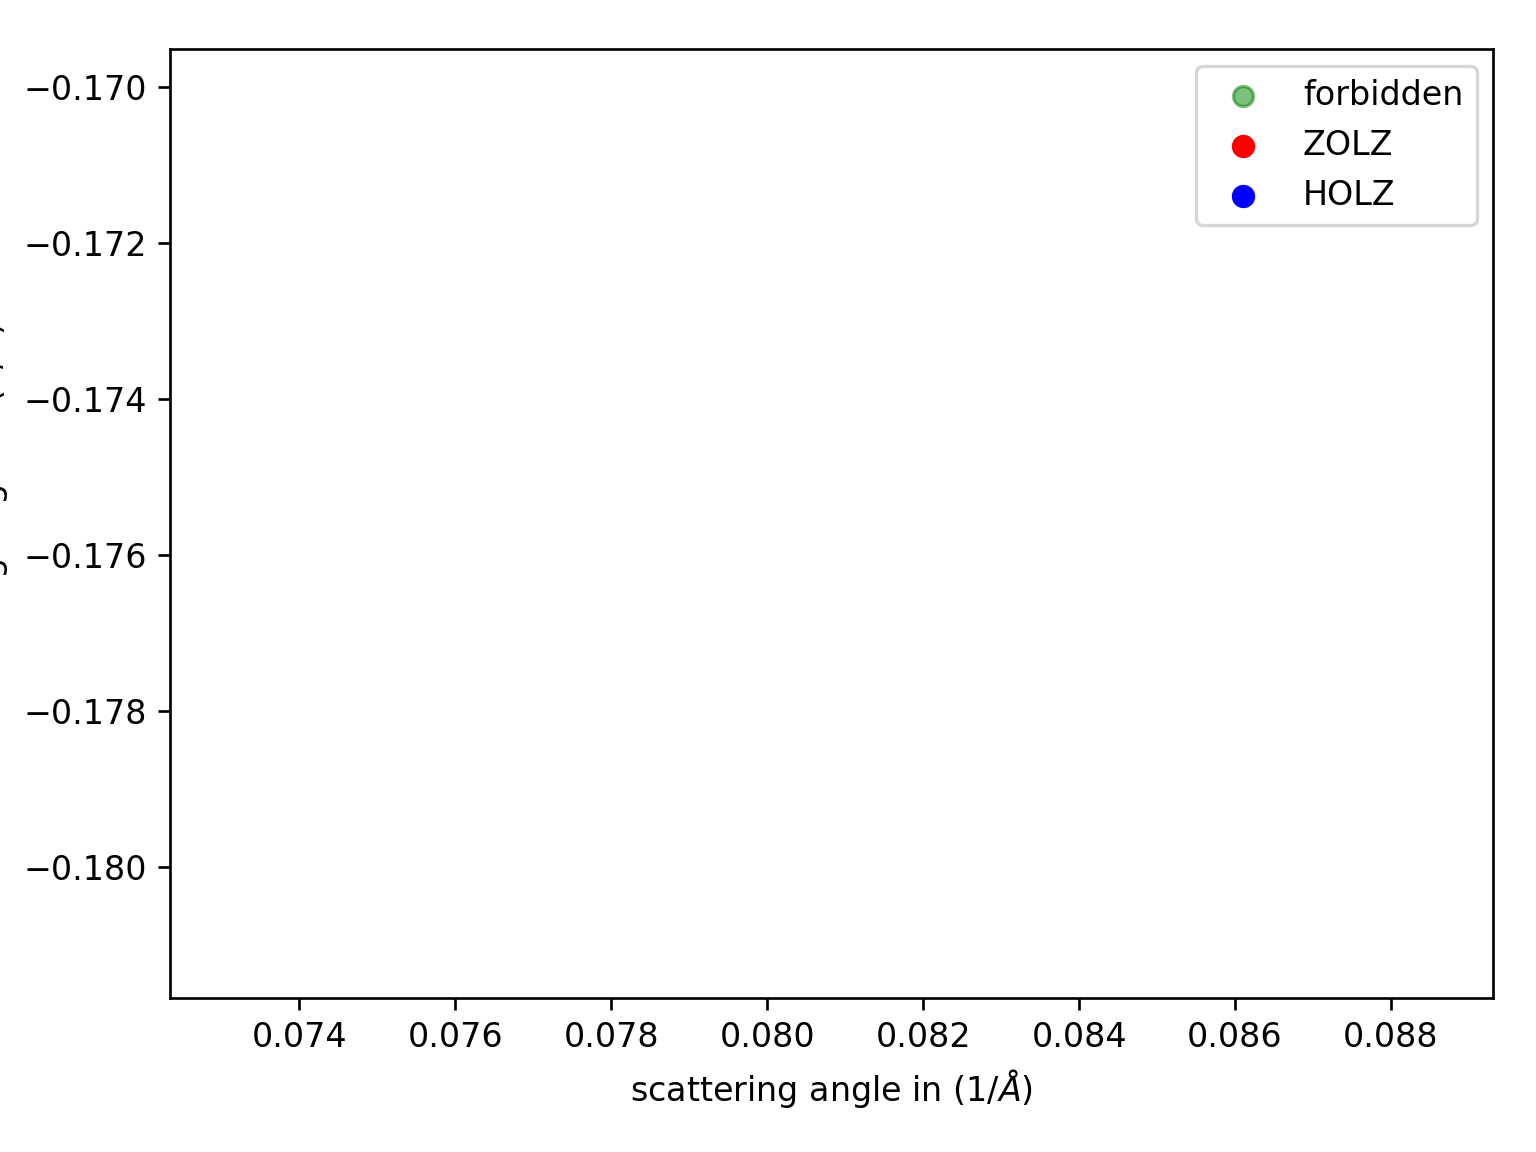

In [12]:

fig = plt.figure()
ax = fig.add_subplot(111)
forbidden = np.dot(g_forbidden, rotation_matrix)
ax.scatter(forbidden[:,0], forbidden[:,1], c='green', alpha = 0.5, label='forbidden')

ax.scatter(g_hkl_rotated[ZOLZ,0], g_hkl_rotated[ZOLZ,1], c='red', label='ZOLZ')
ax.scatter(g_hkl_rotated[HOLZ,0], g_hkl_rotated[HOLZ,1], c='blue', label='HOLZ')
ax.axis('equal')
ax.set_xlabel('scattering angle in (1/$\AA$)')
ax.set_ylabel('scattering angle in (1/$\AA$)')
plt.legend()
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])

plt.tight_layout()

## Kinematic Scattering with pyTEMlib
the kinematic scattering plots can be calculated with the provided kinematic_scattering module of pyTEMlib. All data are gathered in a python dictionary named <b> atoms.info <b>.
    
All *experimental* parameter are stored in *atoms.info['experimental']* dictionary and serve as an input to the kinematic scattering calculations.

All results from the kinematic scattering library are stored in the *atoms.info['diffraction']* dictionary
    
Any additional parameter for the output is stored in the *atoms.info['output']* dictionary
    
    

In [13]:
# copy experimental conditions into the tags directory
atoms.info['experimental'] = {}
atoms.info['experimental']['acceleration_voltage_V'] = acceleration_voltage_V

atoms.info['experimental']['convergence_angle_mrad'] = 0

atoms.info['experimental']['zone_hkl'] = zone_hkl  # incident nearest zone axis: defines Laue Zones!!!!
atoms.info['experimental']['mistilt']  = np.array([0, 0, 0])  # mistilt in degrees

atoms.info['experimental']['Sg_max'] = Sg_max      # 1/Ang  maximum allowed excitation error ; This parameter is related to the thickness
atoms.info['experimental']['hkl_max'] = hkl_max    # Highest evaluated Miller indices
# calculate kinematic scattering data
ks.kinematic_scattering(atoms, verbose=False)
atoms.info['experimental']['plot_FOV'] = 4

# plot diffraction pattern
atoms.info['output'] = pyTEMlib.diffraction_plot.plotSAED_parameter()
atoms.info['output']['plot_labels'] = False
atoms.info['output']['plot_Kikuchi'] = False
atoms.info['output']['plot_dynamically_allowed'] = True 
pyTEMlib.diffraction_plot.plot_diffraction_pattern(atoms)

KeyboardInterrupt: 

In [ ]:
# plot diffraction pattern
atoms.info['output'] = pyTEMlib.diffraction_plot.plotSAED_parameter()
atoms.info['output']['plot_labels'] = False
atoms.info['output']['plot_Kikuchi'] = False
atoms.info['output']['plot_dynamically_allowed'] = True 
pyTEMlib.diffraction_plot.plot_diffraction_pattern(atoms)

In [14]:
atoms.info.keys()
for k, dictionar in atoms.info.items():
    if isinstance(dictionar, dict):
        
        print(k, dictionar.keys())

atoms.info['diffraction']['dynamical_allowed'].keys()

structure dict_keys(['reference', 'link'])
experimental dict_keys(['acceleration_voltage_V', 'convergence_angle_mrad', 'zone_hkl', 'mistilt', 'Sg_max', 'hkl_max', 'mistilt_alpha', 'mistilt_alpha degree', 'mistilt_beta', 'mistilt_beta degree', 'thickness', 'dynamic correction', 'dynamic correction K0', 'wave_length', 'metric_tensor', 'reciprocal_unit_cell', 'inner_potential_V', 'incident_wave_vector_vacuum', 'incident_wave_vector', 'convergence_angle_A-1', 'y-axis rotation alpha', 'x-axis rotation beta', 'rotation_matrix', 'nearest_zone_axis', 'next_nearest_zone_axes', 'mistilt_nearest_zone alpha', 'mistilt_nearest_zone beta', 'nearest_zone_axes'])
output dict_keys(['SpotPattern'])
diffraction dict_keys(['allowed', 'forbidden', 'Laue_circle'])


KeyError: 'dynamical_allowed'

<IPython.core.display.Javascript object>


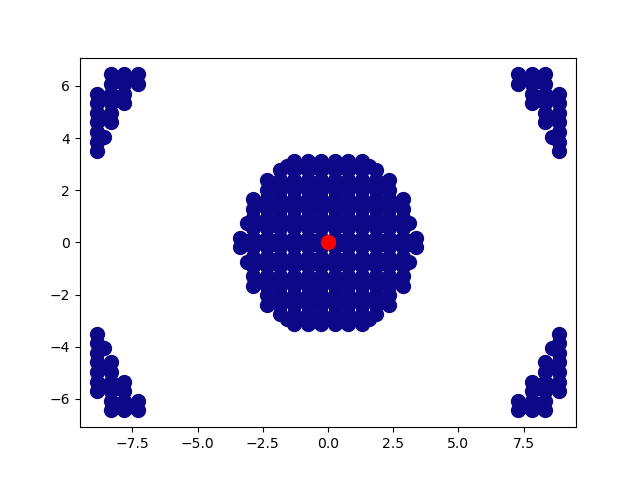

In [14]:
atoms.info['output'] = pyTEMlib.diffraction_plot.plotSAED_parameter()
atoms.info['output']['plot_labels'] = False
atoms.info['output']['plot_Kikuchi'] = False

pyTEMlib.diffraction_plot.plot_diffraction_pattern(atoms)



## Generating Spot Pattern
What needs to be done for a spot pattern

1. Generate the reciprocal lattice
2. Rotate zone axis to coincide with z-axis; Rotate reciprocal lattice the same way.
3. Select all reciprocal lattice points that have an excitation error smaller than S$_{max}$.
4. Determine the allowed reflections of those reciprocal lattice points.
5. Plot these spots (projection is done by ignoring z-axis value, which is the Laue zone).


## Conclusion
The scattering geometry provides all the tools to determine which reciprocal lattice points are possible and which of them are allowed.

The diffraction pattern is a projection onto the plane perpendicular to the zone axis. For an easy projection we tilt everything so that the x,y plane  is our projection plane.

## Dynamically Allowed Reflections
Forbidden Reflection that are a linear combination of two scattering events are called dynamically allowed.

For example, the combination of $[111] + [1\bar{1}\bar{1}]$ reflection gives the in silicon forbidden $[200]$ reflection,
visible in any $\{110\}$ diffraction pattern of silicon.

> Here we test all combinations of any pair of allowed reflections to see whether they are a forbidden one,
in which case they are dynamically activated or dynamically allowed

<IPython.core.display.Javascript object>


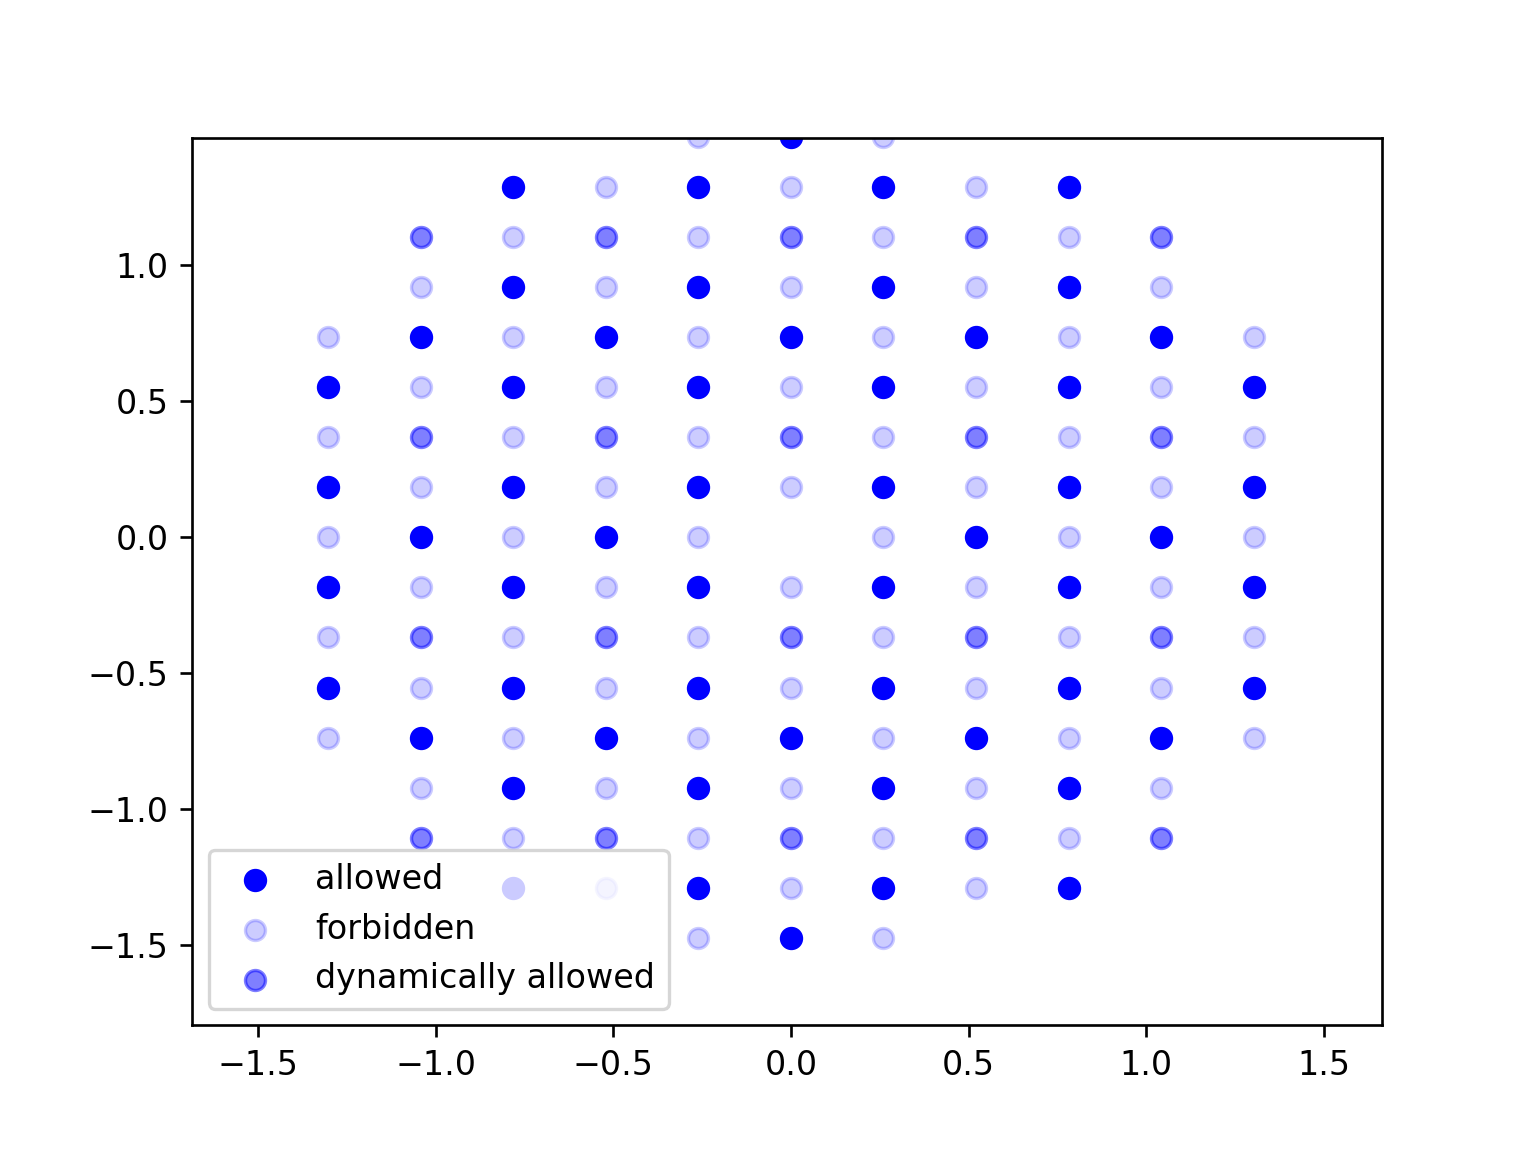

In [15]:
hkl_allowed = atoms.info['diffraction']['allowed']['hkl']
hkl_forbidden = atoms.info['diffraction']['forbidden']['hkl'].tolist()
indices = range(len(hkl_allowed))
combinations = [list(x) for x in itertools.permutations(indices, 2)]

dynamically_allowed = np.zeros(len(hkl_forbidden), dtype=bool)
for [i, j] in combinations:
    possible = (hkl_allowed[i] + hkl_allowed[j]).tolist()
    if possible in hkl_forbidden:
        dynamically_allowed[hkl_forbidden.index(possible)] = True
        
fig = plt.figure()

points = atoms.info['diffraction']['allowed']['g']
plt.scatter(points[:,0], points[:,1], label='allowed', color='blue')
#plt.scatter(points[:,0], points[:,1])
points = atoms.info['diffraction']['forbidden']['g']
plt.scatter(points[np.logical_not(dynamically_allowed),0], points[np.logical_not(dynamically_allowed), 1],
            color='blue', alpha=0.2, label='forbidden')

plt.scatter(points[dynamically_allowed, 0], points[dynamically_allowed, 1],color='blue', alpha=0.5, label='dynamically allowed')
plt.legend()

## Navigation

- <font size = "3">  **Back: [Kinematic Scattering Geometry](CH2_06-Kinematic_Scattering_Geometry.ipynb)** </font>
- <font size = "3">  **Next: [Analyzing Spot Diffraction Pattern](CH2_08-Spot_Diffraction_Pattern.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>